# Module 5: Regime Prediction with Machine Learning - Part 1

In this part, we are going to explain the problem and get familiar with the dataset we are going to use.

&nbsp;&nbsp;1. [Problem Description and Related Work](#1)


&nbsp;&nbsp;2. [Understand Data](#2)   

&nbsp;&nbsp;3. [References](#3) 

## 1. Problem Description and Related Work <a id="1"></a>

Business cycles describe the rise and fall in the growth of the economy that occurs over time. Each business cyle has two turning points trough (or bottom) and peak. Expansion is measured from the trough of the previous business cycle to the peak of the current cycle, while recession is measured from the peak to the trough. 

In the United States (US), the Business Cycle Dating Committee of the National Bureau of Economic Research (NBER) determines the dates for business cycles. The turning points are determined by considering monthly growth indicators of the economy such as industrial production, employment, real income. The main focus of business cycle analysis is to analyze why economy goes through contraction and expansion periods. It is a well-studied topic in the literature and still an active reserach area. In this work, we are going to predict recessions in US economy with leading macroeconomic indicators using machine learning algorithms.

Predicting business cycle turning points, especially economic recessions, is of great importance to investors, households, businesses in the economy.
Starting from &nbsp;[Mitchell and Burns (1938)](#a) pioneering work,  analyzing indicators of business cycles have become a core research area in business cycle analysis and there has been many work done in that field since then. Much of the work in the literature has indicated a wide range of economic and financial variables contain predictive information about future recessions in the economy.&nbsp;[Stock and Watson (1989)](#b) established coincedent and leading economic indicators for recession forecasting. &nbsp;[Estrella and Mishkin (1998)](#c) have documented predictive power of the slope of the term structure of Treasury yields and stock market for US recessions. 
&nbsp;[Liu and Moench (2016)](#f) have also showed the Treasury term spread has the highest predictive power with lagged abservations as well. Also, they indicated that balances in broker-dealer margin accounts have significant effect on recession predictions, especially in longer horizons.
&nbsp;[Chionis et al. (2009)](#d) worked on forecasting recessions in Europe with European Union (EU) data. They found out that the yield curve augmented with the composite stock index has significant predictive
power in terms of the EU real output.
&nbsp;[Ng (2014)](#e) worked on the problem through exploring effectiveness of boosting and found out interest rate measures and certain employment variables have predictive power for the recessions.
Recently, &nbsp;[Huang et al. (2018)](#g) have worked on predictive power of news sentiment analysis on recession forecasting in US economy. 



## 2. Understand Data <a id="2"></a>

In [1]:
# load libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from regimeplot import *

For the analysis we will use a large macroeconomic database from FRED St. Louis designed by [McCracken and Ng (2015)](#i). It involves 129 macroeconomic monthly time series over the period 1959-2018. The data is organized into 8 categories (1)output and income, (2)labor market, (3)housing, (4)consumption, orders and inventories, (5)money and credit, (6)interest and exchange rates, (7)prices and (8)stock market. Detail description of the variables under each category can be found in __[appendix]( https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/Appendix_Tables_Update.pdf)__.

The first row shows the code for necessary transformation that will be performed on the each macroeconomic series. Since the series can be non-stationary, we will convert them into stationary form by applying the neccesary trasnformation as explained in the __[appendix]( https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/Appendix_Tables_Update.pdf)__.

In [2]:
df_macro=pd.read_csv("data/macro_raw.csv")
df_macro=df_macro.rename(columns={'sasdate':'Date'})
df_macro.head()

,Date,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,Transform:,5.000,5.0,5.000,5.0000,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.00,6.00,6.00,2.0,6.0,6.0,6.0,6.0000,1.0
1,1/1/1959,2437.296,2288.8,17.302,292258.8329,18235.77392,22.6250,23.4581,22.1904,32.4078,...,11.358,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2043,NaN
2,2/1/1959,2446.902,2297.0,17.482,294429.5453,18369.56308,23.0681,23.7747,22.3827,32.6455,...,11.375,2.14,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5280,NaN
3,3/1/1959,2462.689,2314.0,17.647,293425.3813,18523.05762,23.4004,23.9186,22.4925,32.6455,...,11.395,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6405,NaN
4,4/1/1959,2478.744,2330.3,17.584,299331.6505,18534.46600,23.8989,24.2641,22.8221,33.1606,...,11.436,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8099,NaN


Consistent with the previous works in the literature, we use __[business cycle dating chronology provided by NBER](http://www.nber.org/cycles.html)__  which involves dates when recession began and ended in US economy. According to NBER's statistics we have 9 recession periods in our dataset where duration is changing from 6 to 18 months. We represent regimes as "Normal" (0) and "Recession" (1) in our dataset. Notice that we have more expansion periods than recessions which means our data is imbalanced. We will consider this issue in error metric selection.

In [3]:
df_recession=pd.read_csv('data/recession_dates.csv',parse_dates = ['Date'])
df_sp500 = pd.read_csv('data/sp500.csv',parse_dates =['Date'],usecols=['Date','Close'])
print('Number of recession periods in the dataset: ', df_recession[df_recession['Regime']==1].shape[0])
print('Number of expansion periods in the dataset: ', df_recession[df_recession['Regime']==0].shape[0])

df_recession = df_recession.merge(df_sp500,on='Date',how='left')

Number of recession periods in the dataset:  100
Number of expansion periods in the dataset:  641


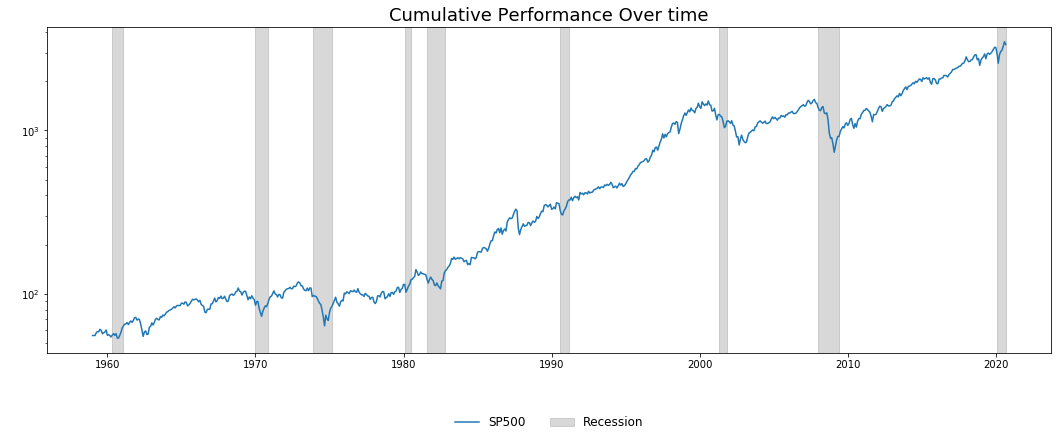

In [4]:
df = RegimePlot(df = df_recession,regime_col='Regime')
df.plt_regime(plt_series = ['Close'],series_label = ['SP500'],regime_label = 'Recession',orj_series = True,log_scale = True)

## 3. References <a id="3"></a>

1. **W. Mitchell and A. Burns.** "Statistical Indicators of Cyclical Revivals", _National Bureau of Economic Research,_ 1938. <a class="anchor" id="a"></a>

2. **J. H. Stock and M. W. Watson.** "New Indexes of Coincedent and Leading Economic Indicators", _NBER Macroeconomics Annual,_ 1989. <a class="anchor" id="b"></a> 

3. **A. Estrella and F. S. Mishkin.** "Predicting U.S. Recessions: Financial Variables as Leading Indicators", _Review of Economics and Statistics,_ 1998. <a class="anchor" id="c"></a>

4. **D. Chionis, P. Gogas and I. Pragidis.** "Predicting Euroepan Union Recessions in the Euro Era: the Yield Curve as a Forecasting Tool of Economic Activity", _International Advances in Economic Research,_ 2009. <a class="anchor" id="d"></a>

5. **S. Ng.** "Viewpoint: Boosting Recessions", _Canadian Journal of Economics,_ 2014. <a class="anchor" id="e"></a>

6. **W. Liu and E. Moench** "What Predicts US Recessions?", _International Journal of Forecasting,_ 2016. <a class="anchor" id="f"></a>

7. **M. Y. Huang, R. R. Rojas and P. D. Convery.** " News Sentiment as Leading Indicators for Recessions", _arXiv,_ 2018. <a id="g"></a>

8. **M. McCracken and S. Ng** "__[FRED-MD: A Monthly Database for Macroeconomic Research](https://research.stlouisfed.org/econ/mccracken/fred-databases/)__", _Working Paper,_ 2015.  <a class="anchor" id="i"></a>


